In [1]:
import pandas as pd
import numpy as np
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [23]:
#Helper functions for the data processing
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    #print(big_string)
    return np.nan

def replace_titles(x):
    title=x['Title']
    if title in ['Don']:
        return 1
    elif title in ['Major']:
        return 2
    elif title in ['Capt']:
        return 3
    elif title in ['Jonkheer']:
        return 4
    elif title in ['Rev']:
        return 5
    elif title in ['Col']:
        return 6
    elif title in ['Mr']:
        return 7
    elif title in ['Master']:
        return 8 
    elif title in ['Countess']:
        return 9
    elif title in ['Mrs']:
        return 10
    elif title in ['Mme']:
        return 11
    elif title in ['Mlle']:
        return 12
    elif title in ['Miss']:
        return 13
    elif title in ['Ms']:
        return 14
    elif title =='Dr':
        if x['Sex']=='female':
            return 16
        else:
            return 17
    else:
        return title 
                   
#The data processing for the training and testing data sets
def data_train_simple(filename, split = True):
    train_data = pd.read_csv(filename)
    
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                        'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                        'Don', 'Jonkheer']

    train_data['Title'] = train_data['Name'].map(lambda x: substrings_in_string(x, title_list))   
    train_data['Title'] = train_data.apply(replace_titles, axis=1)
    train_data['Title'] = train_data['Title'].fillna(-2)
    
    #Turning cabin number into Deck
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    train_data['Cabin'] = train_data['Cabin'].astype(str)
    train_data['Deck'] = train_data['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
    
    train_data.loc[(train_data.Deck == 'A'),'Deck'] = 1
    train_data.loc[(train_data.Deck == 'B'),'Deck'] = 2
    train_data.loc[(train_data.Deck == 'C'),'Deck'] = 3
    train_data.loc[(train_data.Deck == 'D'),'Deck'] = 4
    train_data.loc[(train_data.Deck == 'E'),'Deck'] = 5
    train_data.loc[(train_data.Deck == 'F'),'Deck'] = 6
    train_data.loc[(train_data.Deck == 'T'),'Deck'] = 7
    train_data.loc[(train_data.Deck == 'G'),'Deck'] = 8
    train_data['Deck'] = train_data['Deck'].fillna(0)
    
    train_data['Family_Size'] = train_data['SibSp'] + train_data['Parch']
    train_data.loc[(train_data.Family_Size == 0),'Family_Size'] = 1
    
    train_data.loc[(train_data.Sex == 'female'),'Sex'] = 1
    train_data.loc[(train_data.Sex == 'male'),'Sex'] = 0
    
    train_data.loc[(train_data.Embarked == 'C'),'Embarked'] = 1
    train_data.loc[(train_data.Embarked == 'Q'),'Embarked'] = 2
    train_data.loc[(train_data.Embarked == 'S'),'Embarked'] = 3
    train_data['Embarked'] = train_data['Embarked'].fillna(0)
    
    train_data['Fare_Per_Person'] = train_data['Fare']  / (train_data['Family_Size']+1)
    
    age_mean = train_data['Age'].mean(skipna = True)
    train_data['Age'] = train_data['Age'].fillna(age_mean)
    
    train_data['Minor'] = 0
    train_data.loc[(train_data.Minor <= 12),'Minor'] = 1
    train_data.loc[(train_data.Minor > 12),'Minor'] = 0
    
    train_data['Minor/Female'] = 0
    train_data['Minor/Male'] = 0
    train_data.loc[(train_data.Minor == 1) & (train_data.Sex == 1), 'Minor/Female'] = 1
    train_data.loc[(train_data.Minor == 1) & (train_data.Sex == 0),'Minor/Male'] = 1
    
    train_data['Minor/Survival'] = .37
    train_data.loc[(train_data.Minor == 1),'Minor/Survival'] = .5
    
    train_data['Adult/Female'] = .28
    train_data['Adult/Male'] = .84
    train_data.loc[(train_data.Minor == 0) & (train_data.Sex == 1), 'Adult/Female'] = .72
    train_data.loc[(train_data.Minor == 0) & (train_data.Sex == 0),'Adult/Male'] = .16
    
    train_data['Minor/1'] = .14
    train_data['Minor/2'] = 0
    train_data['Minor/3'] = .69
    train_data.loc[(train_data.Minor == 1) & (train_data.Pclass == 1), 'Minor/1'] = .86
    train_data.loc[(train_data.Minor == 1) & (train_data.Pclass == 2),'Minor/2'] = 1
    train_data.loc[(train_data.Minor == 1) & (train_data.Pclass == 3),'Minor/3'] = .31
    
    train_data['Male/1'] = .62
    train_data['Male/2'] = .43
    train_data['Male/3'] = .25
    train_data.loc[(train_data.Minor == 0) & (train_data.Pclass == 1) & (train_data.Sex == 0), 'Male/1'] = .32
    train_data.loc[(train_data.Minor == 0) & (train_data.Pclass == 2) & (train_data.Sex == 0),'Male/2'] = .8
    train_data.loc[(train_data.Minor == 0) & (train_data.Pclass == 3) & (train_data.Sex == 0),'Male/3'] = .13
    
    train_data['Female/1'] = .03
    train_data['Female/2'] = .14
    train_data['Female/3'] = .51
    train_data.loc[(train_data.Minor == 0) & (train_data.Pclass == 1) & (train_data.Sex == 1), 'Female/1'] = .97
    train_data.loc[(train_data.Minor == 0) & (train_data.Pclass == 2) & (train_data.Sex == 1),'Female/2'] = .86
    train_data.loc[(train_data.Minor == 0) & (train_data.Pclass == 3) & (train_data.Sex == 1),'Female/3'] = .49
    
    train_data['Minor/C'] = .37
    train_data['Male/C'] = .85
    train_data['Female/C'] = .39
    train_data.loc[(train_data.Minor == 1) & (train_data.Pclass == 3) & (train_data.Embarked == 1), 'Minor/C'] = .63
    train_data.loc[(train_data.Minor == 0) & (train_data.Sex == 0) & (train_data.Pclass == 3) & (train_data.Embarked == 1), 'Male/C'] = .15
    train_data.loc[(train_data.Minor == 0) & (train_data.Sex == 1) & (train_data.Pclass == 3) & (train_data.Embarked == 1), 'Female/C'] = .61
    
    train_data['Minor/Q'] = .83
    train_data['Male/Q'] = .91
    train_data['Female/Q'] = .43
    train_data.loc[(train_data.Minor == 1) & (train_data.Pclass == 3) & (train_data.Embarked == 2), 'Minor/Q'] = .17
    train_data.loc[(train_data.Minor == 0) & (train_data.Sex == 0) & (train_data.Pclass == 3) & (train_data.Embarked == 2), 'Male/Q'] = .9
    train_data.loc[(train_data.Minor == 0) & (train_data.Sex == 1) & (train_data.Pclass == 3) & (train_data.Embarked == 2), 'Female/Q'] = .57
    
    train_data['Minor/S'] = .72
    train_data['Male/S'] = .86
    train_data['Female/S'] = .59
    train_data.loc[(train_data.Minor == 1) & (train_data.Pclass == 3) & (train_data.Embarked == 2), 'Minor/S'] = .28
    train_data.loc[(train_data.Minor == 0) & (train_data.Sex == 0) & (train_data.Pclass == 3) & (train_data.Embarked == 2), 'Male/S'] = .14
    train_data.loc[(train_data.Minor == 0) & (train_data.Sex == 1) & (train_data.Pclass == 3) & (train_data.Embarked == 2), 'Female/S'] = .41
    
    tmp = train_data[['Pclass','Sex','Age','Minor','Minor/C','Male/C','Female/C','Minor/S','Male/S',
                      'Female/S','Minor/Q','Male/Q','Female/Q','Embarked','Female/1','Female/2',
                      'Female/3','Male/1','Male/2','Male/3','Minor/1','Minor/2','Minor/3',
                      'Minor/Female','Minor/Male','Minor/Survival','Adult/Female','Adult/Male', 'Title',
                     'Deck', 'Family_Size', 'Fare_Per_Person']].copy()
    
    X = pd.DataFrame(tmp).to_numpy()
    X = X.T
    X = np.float32(X)
    
    if split == True:
        m = X.shape[1]
        Y = np.array([train_data['Survived'].values])
        Y = np.float32(Y)
        
        #Shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuff_X = X[:, permutation]
        shuff_Y = Y[:, permutation].reshape((1,m))
    
        devM = round(m * .5)
        devM2 = m - devM
        
        train_X = shuff_X[:, 0:(devM2)]
        train_Y = shuff_Y[:, 0:(devM2)]
        dev_X = shuff_X[:, -(devM + 1):-1]
        dev_Y = shuff_Y[:, -(devM + 1):-1]
        
        m_train = train_X.shape[1]
        m_test = dev_X.shape[1]
        
        print ("Number of testing examples: m_test = " + str(m_test))
        print ("test_set_x shape: " + str(dev_X.shape))
        print ("test_set_y shape: " + str(dev_Y.shape))
        print ("Number of training examples: m_train = " + str(m_train))
        print ("train_set_x shape: " + str(train_X.shape))
        print ("train_set_y shape: " + str(train_Y.shape))
        
        return train_X, train_Y, dev_X, dev_Y
    
    return X
    
train_X, train_Y, dev_X, dev_Y = data_train_simple("train.csv", split = True)

Number of testing examples: m_test = 446
test_set_x shape: (32, 446)
test_set_y shape: (1, 446)
Number of training examples: m_train = 445
train_set_x shape: (32, 445)
train_set_y shape: (1, 445)


In [26]:
activation = 'relu'
optimizer = keras.optimizers.Adam(0.00055)
l = 0.007
he = keras.initializers.he_normal(seed=None)

model = models.Sequential()
model.add(layers.Dense(128, activation=activation, kernel_initializer=he, bias_initializer=he, kernel_regularizer=keras.regularizers.l2(l=l), input_shape=(train_X.shape[0],)))
model.add(layers.Dense(128, activation=activation, kernel_initializer=he, bias_initializer=he, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(128, activation=activation, kernel_initializer=he, bias_initializer=he, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(128, activation=activation, kernel_initializer=he, bias_initializer=he, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(128, activation=activation, kernel_initializer=he, bias_initializer=he, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(128, activation=activation, kernel_initializer=he, bias_initializer=he, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(128, activation=activation, kernel_initializer=he, bias_initializer=he, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(128, activation=activation, kernel_initializer=he, bias_initializer=he, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(128, activation=activation, kernel_initializer=he, bias_initializer=he, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(128, activation=activation, kernel_initializer=he, bias_initializer=he, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(128, activation=activation, kernel_initializer=he, bias_initializer=he, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(128, activation=activation, kernel_initializer=he, bias_initializer=he, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_X.T, train_Y.T,
                    epochs=5000,
                    batch_size=16,
                    validation_data=(dev_X.T, dev_Y.T)
                   )

Train on 445 samples, validate on 446 samples
Epoch 1/5000
445/445 [==============================] - 0s 1ms/step - loss: 21.4387 - accuracy: 0.6180 - val_loss: 20.2318 - val_accuracy: 0.5336
Epoch 2/5000
445/445 [==============================] - 0s 191us/step - loss: 19.2172 - accuracy: 0.6809 - val_loss: 18.3152 - val_accuracy: 0.7085
Epoch 3/5000
445/445 [==============================] - 0s 198us/step - loss: 17.5705 - accuracy: 0.7258 - val_loss: 16.7946 - val_accuracy: 0.7130
Epoch 4/5000
445/445 [==============================] - 0s 193us/step - loss: 16.1427 - accuracy: 0.7663 - val_loss: 15.5774 - val_accuracy: 0.7489
Epoch 5/5000
445/445 [==============================] - 0s 187us/step - loss: 14.9595 - accuracy: 0.7820 - val_loss: 14.4928 - val_accuracy: 0.7220
Epoch 6/5000
445/445 [==============================] - 0s 180us/step - loss: 13.9883 - accuracy: 0.7730 - val_loss: 13.6487 - val_accuracy: 0.7511
Epoch 7/5000
445/445 [==============================] - 0s 184us/ste

445/445 [==============================] - 0s 184us/step - loss: 2.9584 - accuracy: 0.7640 - val_loss: 2.9667 - val_accuracy: 0.7511
Epoch 57/5000
445/445 [==============================] - 0s 182us/step - loss: 2.8689 - accuracy: 0.7888 - val_loss: 2.8279 - val_accuracy: 0.7960
Epoch 58/5000
445/445 [==============================] - 0s 182us/step - loss: 2.7845 - accuracy: 0.7933 - val_loss: 2.7606 - val_accuracy: 0.8139
Epoch 59/5000
445/445 [==============================] - 0s 184us/step - loss: 2.7240 - accuracy: 0.8112 - val_loss: 2.7064 - val_accuracy: 0.8094
Epoch 60/5000
445/445 [==============================] - 0s 189us/step - loss: 2.6666 - accuracy: 0.8000 - val_loss: 2.6412 - val_accuracy: 0.8274
Epoch 61/5000
445/445 [==============================] - 0s 173us/step - loss: 2.6194 - accuracy: 0.7843 - val_loss: 2.6162 - val_accuracy: 0.7803
Epoch 62/5000
445/445 [==============================] - 0s 178us/step - loss: 2.5506 - accuracy: 0.8112 - val_loss: 2.5524 - val_ac

Epoch 112/5000
445/445 [==============================] - 0s 178us/step - loss: 1.1231 - accuracy: 0.7888 - val_loss: 1.1229 - val_accuracy: 0.8094
Epoch 113/5000
445/445 [==============================] - 0s 178us/step - loss: 1.1030 - accuracy: 0.8112 - val_loss: 1.1277 - val_accuracy: 0.8206
Epoch 114/5000
445/445 [==============================] - 0s 178us/step - loss: 1.1082 - accuracy: 0.8090 - val_loss: 1.1702 - val_accuracy: 0.7444
Epoch 115/5000
445/445 [==============================] - 0s 181us/step - loss: 1.0890 - accuracy: 0.7955 - val_loss: 1.1521 - val_accuracy: 0.7511
Epoch 116/5000
445/445 [==============================] - 0s 178us/step - loss: 1.0635 - accuracy: 0.8045 - val_loss: 1.0717 - val_accuracy: 0.8094
Epoch 117/5000
445/445 [==============================] - 0s 176us/step - loss: 1.0627 - accuracy: 0.7933 - val_loss: 1.0565 - val_accuracy: 0.8206
Epoch 118/5000
445/445 [==============================] - 0s 187us/step - loss: 1.0362 - accuracy: 0.8000 - val_

445/445 [==============================] - 0s 189us/step - loss: 0.7411 - accuracy: 0.7978 - val_loss: 0.7187 - val_accuracy: 0.8229
Epoch 168/5000
445/445 [==============================] - 0s 189us/step - loss: 0.7306 - accuracy: 0.8090 - val_loss: 0.7259 - val_accuracy: 0.8072
Epoch 169/5000
445/445 [==============================] - 0s 184us/step - loss: 0.7081 - accuracy: 0.7978 - val_loss: 0.7202 - val_accuracy: 0.8117
Epoch 170/5000
445/445 [==============================] - 0s 189us/step - loss: 0.7130 - accuracy: 0.8090 - val_loss: 0.7539 - val_accuracy: 0.8004
Epoch 171/5000
445/445 [==============================] - 0s 205us/step - loss: 0.7034 - accuracy: 0.8112 - val_loss: 0.7120 - val_accuracy: 0.8117
Epoch 172/5000
445/445 [==============================] - 0s 187us/step - loss: 0.7150 - accuracy: 0.7910 - val_loss: 0.7111 - val_accuracy: 0.8139
Epoch 173/5000
445/445 [==============================] - 0s 189us/step - loss: 0.7075 - accuracy: 0.8000 - val_loss: 0.7191 - 

445/445 [==============================] - 0s 178us/step - loss: 0.6250 - accuracy: 0.7955 - val_loss: 0.6594 - val_accuracy: 0.7758
Epoch 223/5000
445/445 [==============================] - 0s 178us/step - loss: 0.6516 - accuracy: 0.7978 - val_loss: 0.6508 - val_accuracy: 0.7915
Epoch 224/5000
445/445 [==============================] - 0s 175us/step - loss: 0.6391 - accuracy: 0.8022 - val_loss: 0.6368 - val_accuracy: 0.8049
Epoch 225/5000
445/445 [==============================] - 0s 178us/step - loss: 0.6308 - accuracy: 0.7933 - val_loss: 0.6275 - val_accuracy: 0.8117
Epoch 226/5000
445/445 [==============================] - 0s 178us/step - loss: 0.6220 - accuracy: 0.8045 - val_loss: 0.6302 - val_accuracy: 0.8363
Epoch 227/5000
445/445 [==============================] - 0s 182us/step - loss: 0.6315 - accuracy: 0.8090 - val_loss: 0.6595 - val_accuracy: 0.7803
Epoch 228/5000
445/445 [==============================] - 0s 187us/step - loss: 0.6134 - accuracy: 0.8112 - val_loss: 0.6542 - 

445/445 [==============================] - 0s 191us/step - loss: 0.5892 - accuracy: 0.8135 - val_loss: 0.5997 - val_accuracy: 0.8386
Epoch 278/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5738 - accuracy: 0.8180 - val_loss: 0.6158 - val_accuracy: 0.8004
Epoch 279/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5795 - accuracy: 0.8225 - val_loss: 0.6226 - val_accuracy: 0.7892
Epoch 280/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5747 - accuracy: 0.8135 - val_loss: 0.5974 - val_accuracy: 0.8274
Epoch 281/5000
445/445 [==============================] - 0s 191us/step - loss: 0.5907 - accuracy: 0.8247 - val_loss: 0.6312 - val_accuracy: 0.7870
Epoch 282/5000
445/445 [==============================] - 0s 178us/step - loss: 0.5814 - accuracy: 0.8270 - val_loss: 0.6686 - val_accuracy: 0.7556
Epoch 283/5000
445/445 [==============================] - 0s 178us/step - loss: 0.5942 - accuracy: 0.8135 - val_loss: 0.6208 - 

445/445 [==============================] - 0s 175us/step - loss: 0.5678 - accuracy: 0.8045 - val_loss: 0.6032 - val_accuracy: 0.8027
Epoch 333/5000
445/445 [==============================] - 0s 175us/step - loss: 0.5537 - accuracy: 0.8135 - val_loss: 0.5784 - val_accuracy: 0.8206
Epoch 334/5000
445/445 [==============================] - 0s 178us/step - loss: 0.5608 - accuracy: 0.8045 - val_loss: 0.6010 - val_accuracy: 0.7915
Epoch 335/5000
445/445 [==============================] - 0s 187us/step - loss: 0.5827 - accuracy: 0.8045 - val_loss: 0.5772 - val_accuracy: 0.8318
Epoch 336/5000
445/445 [==============================] - 0s 175us/step - loss: 0.5541 - accuracy: 0.8157 - val_loss: 0.5879 - val_accuracy: 0.8139
Epoch 337/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5635 - accuracy: 0.8022 - val_loss: 0.5851 - val_accuracy: 0.8139
Epoch 338/5000
445/445 [==============================] - 0s 189us/step - loss: 0.5650 - accuracy: 0.8180 - val_loss: 0.5863 - 

445/445 [==============================] - 0s 182us/step - loss: 0.5431 - accuracy: 0.8292 - val_loss: 0.5795 - val_accuracy: 0.8229
Epoch 388/5000
445/445 [==============================] - 0s 189us/step - loss: 0.5471 - accuracy: 0.8157 - val_loss: 0.6896 - val_accuracy: 0.7511
Epoch 389/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5810 - accuracy: 0.8022 - val_loss: 0.5907 - val_accuracy: 0.8004
Epoch 390/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5415 - accuracy: 0.8180 - val_loss: 0.5849 - val_accuracy: 0.8094
Epoch 391/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5535 - accuracy: 0.8112 - val_loss: 0.6155 - val_accuracy: 0.7848
Epoch 392/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5554 - accuracy: 0.8180 - val_loss: 0.5688 - val_accuracy: 0.8318
Epoch 393/5000
445/445 [==============================] - 0s 184us/step - loss: 0.5460 - accuracy: 0.8135 - val_loss: 0.5709 - 

445/445 [==============================] - 0s 180us/step - loss: 0.5559 - accuracy: 0.8000 - val_loss: 0.5691 - val_accuracy: 0.8161
Epoch 443/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5435 - accuracy: 0.8180 - val_loss: 0.5734 - val_accuracy: 0.8296
Epoch 444/5000
445/445 [==============================] - 0s 178us/step - loss: 0.5412 - accuracy: 0.8292 - val_loss: 0.5795 - val_accuracy: 0.7915
Epoch 445/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5456 - accuracy: 0.8135 - val_loss: 0.6306 - val_accuracy: 0.7691
Epoch 446/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5495 - accuracy: 0.8157 - val_loss: 0.5949 - val_accuracy: 0.7982
Epoch 447/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5500 - accuracy: 0.8180 - val_loss: 0.6229 - val_accuracy: 0.7668
Epoch 448/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5404 - accuracy: 0.8247 - val_loss: 0.5890 - 

445/445 [==============================] - 0s 180us/step - loss: 0.5488 - accuracy: 0.8157 - val_loss: 0.5748 - val_accuracy: 0.8117
Epoch 498/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5433 - accuracy: 0.8157 - val_loss: 0.5733 - val_accuracy: 0.8139
Epoch 499/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5343 - accuracy: 0.8135 - val_loss: 0.5595 - val_accuracy: 0.8229
Epoch 500/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5421 - accuracy: 0.8135 - val_loss: 0.6264 - val_accuracy: 0.7556
Epoch 501/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5422 - accuracy: 0.8225 - val_loss: 0.5588 - val_accuracy: 0.8161
Epoch 502/5000
445/445 [==============================] - 0s 189us/step - loss: 0.5280 - accuracy: 0.8270 - val_loss: 0.5606 - val_accuracy: 0.8296
Epoch 503/5000
445/445 [==============================] - 0s 189us/step - loss: 0.5349 - accuracy: 0.8449 - val_loss: 0.5668 - 

445/445 [==============================] - 0s 193us/step - loss: 0.5387 - accuracy: 0.8315 - val_loss: 0.6118 - val_accuracy: 0.7735
Epoch 553/5000
445/445 [==============================] - 0s 191us/step - loss: 0.5265 - accuracy: 0.8404 - val_loss: 0.5710 - val_accuracy: 0.8094
Epoch 554/5000
445/445 [==============================] - 0s 189us/step - loss: 0.5162 - accuracy: 0.8225 - val_loss: 0.5668 - val_accuracy: 0.8184
Epoch 555/5000
445/445 [==============================] - 0s 189us/step - loss: 0.5209 - accuracy: 0.8315 - val_loss: 0.5686 - val_accuracy: 0.8027
Epoch 556/5000
445/445 [==============================] - 0s 187us/step - loss: 0.5506 - accuracy: 0.8022 - val_loss: 0.5960 - val_accuracy: 0.7848
Epoch 557/5000
445/445 [==============================] - 0s 189us/step - loss: 0.5296 - accuracy: 0.8404 - val_loss: 0.5690 - val_accuracy: 0.8139
Epoch 558/5000
445/445 [==============================] - 0s 189us/step - loss: 0.5248 - accuracy: 0.8562 - val_loss: 0.5565 - 

445/445 [==============================] - 0s 187us/step - loss: 0.5220 - accuracy: 0.8157 - val_loss: 0.5552 - val_accuracy: 0.8139
Epoch 608/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5239 - accuracy: 0.8337 - val_loss: 0.5619 - val_accuracy: 0.8296
Epoch 609/5000
445/445 [==============================] - 0s 184us/step - loss: 0.5187 - accuracy: 0.8360 - val_loss: 0.5741 - val_accuracy: 0.8117
Epoch 610/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5254 - accuracy: 0.8360 - val_loss: 0.6326 - val_accuracy: 0.7691
Epoch 611/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5399 - accuracy: 0.8202 - val_loss: 0.5945 - val_accuracy: 0.7870
Epoch 612/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5145 - accuracy: 0.8337 - val_loss: 0.5637 - val_accuracy: 0.8296
Epoch 613/5000
445/445 [==============================] - 0s 175us/step - loss: 0.5195 - accuracy: 0.8360 - val_loss: 0.5534 - 

445/445 [==============================] - 0s 175us/step - loss: 0.5064 - accuracy: 0.8360 - val_loss: 0.6327 - val_accuracy: 0.7713
Epoch 663/5000
445/445 [==============================] - 0s 178us/step - loss: 0.5179 - accuracy: 0.8315 - val_loss: 0.5504 - val_accuracy: 0.8251
Epoch 664/5000
445/445 [==============================] - 0s 189us/step - loss: 0.5176 - accuracy: 0.8180 - val_loss: 0.6342 - val_accuracy: 0.7691
Epoch 665/5000
445/445 [==============================] - 0s 178us/step - loss: 0.5297 - accuracy: 0.8225 - val_loss: 0.5522 - val_accuracy: 0.8251
Epoch 666/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5202 - accuracy: 0.8315 - val_loss: 0.5539 - val_accuracy: 0.8184
Epoch 667/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5402 - accuracy: 0.8135 - val_loss: 0.6877 - val_accuracy: 0.7489
Epoch 668/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5361 - accuracy: 0.8112 - val_loss: 0.6160 - 

445/445 [==============================] - 0s 184us/step - loss: 0.5579 - accuracy: 0.8112 - val_loss: 0.5603 - val_accuracy: 0.8072
Epoch 718/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5169 - accuracy: 0.8315 - val_loss: 0.5600 - val_accuracy: 0.8206
Epoch 719/5000
445/445 [==============================] - 0s 184us/step - loss: 0.5206 - accuracy: 0.8360 - val_loss: 0.5581 - val_accuracy: 0.8296
Epoch 720/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5219 - accuracy: 0.8337 - val_loss: 0.5604 - val_accuracy: 0.8049
Epoch 721/5000
445/445 [==============================] - 0s 178us/step - loss: 0.5180 - accuracy: 0.8382 - val_loss: 0.6155 - val_accuracy: 0.7848
Epoch 722/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5164 - accuracy: 0.8270 - val_loss: 0.5563 - val_accuracy: 0.8094
Epoch 723/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5308 - accuracy: 0.8225 - val_loss: 0.6307 - 

445/445 [==============================] - 0s 180us/step - loss: 0.5057 - accuracy: 0.8270 - val_loss: 0.6019 - val_accuracy: 0.7960
Epoch 773/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5057 - accuracy: 0.8337 - val_loss: 0.6113 - val_accuracy: 0.7892
Epoch 774/5000
445/445 [==============================] - 0s 178us/step - loss: 0.5069 - accuracy: 0.8315 - val_loss: 0.5560 - val_accuracy: 0.8296
Epoch 775/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5008 - accuracy: 0.8382 - val_loss: 0.5798 - val_accuracy: 0.8049
Epoch 776/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5252 - accuracy: 0.8270 - val_loss: 0.5468 - val_accuracy: 0.8206
Epoch 777/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4992 - accuracy: 0.8494 - val_loss: 0.5533 - val_accuracy: 0.8296
Epoch 778/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4926 - accuracy: 0.8449 - val_loss: 0.6629 - 

445/445 [==============================] - 0s 180us/step - loss: 0.4953 - accuracy: 0.8472 - val_loss: 0.5608 - val_accuracy: 0.8206
Epoch 828/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5016 - accuracy: 0.8404 - val_loss: 0.5556 - val_accuracy: 0.8094
Epoch 829/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5126 - accuracy: 0.8292 - val_loss: 0.5810 - val_accuracy: 0.8094
Epoch 830/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5108 - accuracy: 0.8315 - val_loss: 0.5941 - val_accuracy: 0.7870
Epoch 831/5000
445/445 [==============================] - 0s 187us/step - loss: 0.5049 - accuracy: 0.8472 - val_loss: 0.5563 - val_accuracy: 0.8274
Epoch 832/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4997 - accuracy: 0.8472 - val_loss: 0.6509 - val_accuracy: 0.7623
Epoch 833/5000
445/445 [==============================] - 0s 178us/step - loss: 0.5191 - accuracy: 0.8315 - val_loss: 0.5625 - 

445/445 [==============================] - 0s 196us/step - loss: 0.4985 - accuracy: 0.8360 - val_loss: 0.5560 - val_accuracy: 0.8274
Epoch 883/5000
445/445 [==============================] - 0s 191us/step - loss: 0.4962 - accuracy: 0.8427 - val_loss: 0.5814 - val_accuracy: 0.8117
Epoch 884/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4969 - accuracy: 0.8697 - val_loss: 0.6966 - val_accuracy: 0.7623
Epoch 885/5000
445/445 [==============================] - 0s 189us/step - loss: 0.5410 - accuracy: 0.8180 - val_loss: 0.5430 - val_accuracy: 0.8229
Epoch 886/5000
445/445 [==============================] - 0s 187us/step - loss: 0.5124 - accuracy: 0.8202 - val_loss: 0.5559 - val_accuracy: 0.8251
Epoch 887/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4927 - accuracy: 0.8472 - val_loss: 0.5625 - val_accuracy: 0.8251
Epoch 888/5000
445/445 [==============================] - 0s 187us/step - loss: 0.5126 - accuracy: 0.8315 - val_loss: 0.5519 - 

445/445 [==============================] - 0s 180us/step - loss: 0.4978 - accuracy: 0.8360 - val_loss: 0.5631 - val_accuracy: 0.8004
Epoch 938/5000
445/445 [==============================] - 0s 184us/step - loss: 0.5122 - accuracy: 0.8270 - val_loss: 0.5800 - val_accuracy: 0.8184
Epoch 939/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4871 - accuracy: 0.8494 - val_loss: 0.5479 - val_accuracy: 0.8184
Epoch 940/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4984 - accuracy: 0.8517 - val_loss: 0.5462 - val_accuracy: 0.8161
Epoch 941/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4812 - accuracy: 0.8562 - val_loss: 0.5581 - val_accuracy: 0.8161
Epoch 942/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4879 - accuracy: 0.8494 - val_loss: 0.6409 - val_accuracy: 0.7870
Epoch 943/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5049 - accuracy: 0.8382 - val_loss: 0.5515 - 

445/445 [==============================] - 0s 182us/step - loss: 0.5020 - accuracy: 0.8427 - val_loss: 0.5716 - val_accuracy: 0.8206
Epoch 993/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5018 - accuracy: 0.8360 - val_loss: 0.5633 - val_accuracy: 0.8117
Epoch 994/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4886 - accuracy: 0.8449 - val_loss: 0.5473 - val_accuracy: 0.8251
Epoch 995/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4965 - accuracy: 0.8427 - val_loss: 0.6689 - val_accuracy: 0.7713
Epoch 996/5000
445/445 [==============================] - 0s 184us/step - loss: 0.5080 - accuracy: 0.8337 - val_loss: 0.5477 - val_accuracy: 0.8139
Epoch 997/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5188 - accuracy: 0.8135 - val_loss: 0.5933 - val_accuracy: 0.8161
Epoch 998/5000
445/445 [==============================] - 0s 180us/step - loss: 0.5024 - accuracy: 0.8315 - val_loss: 0.5459 - 

445/445 [==============================] - 0s 183us/step - loss: 0.4931 - accuracy: 0.8360 - val_loss: 0.5779 - val_accuracy: 0.8161
Epoch 1048/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4679 - accuracy: 0.8719 - val_loss: 0.5608 - val_accuracy: 0.8161
Epoch 1049/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4734 - accuracy: 0.8562 - val_loss: 0.6523 - val_accuracy: 0.7713
Epoch 1050/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4879 - accuracy: 0.8449 - val_loss: 0.5970 - val_accuracy: 0.8004
Epoch 1051/5000
445/445 [==============================] - 0s 193us/step - loss: 0.5112 - accuracy: 0.8337 - val_loss: 0.5769 - val_accuracy: 0.8229
Epoch 1052/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4956 - accuracy: 0.8472 - val_loss: 0.5518 - val_accuracy: 0.8206
Epoch 1053/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4719 - accuracy: 0.8584 - val_loss: 0.6

445/445 [==============================] - 0s 178us/step - loss: 0.4826 - accuracy: 0.8517 - val_loss: 0.5699 - val_accuracy: 0.8251
Epoch 1103/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4761 - accuracy: 0.8539 - val_loss: 0.5558 - val_accuracy: 0.8139
Epoch 1104/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4664 - accuracy: 0.8719 - val_loss: 0.5557 - val_accuracy: 0.8139
Epoch 1105/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4868 - accuracy: 0.8472 - val_loss: 0.5424 - val_accuracy: 0.8430
Epoch 1106/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4718 - accuracy: 0.8584 - val_loss: 0.5532 - val_accuracy: 0.8094
Epoch 1107/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4851 - accuracy: 0.8449 - val_loss: 0.5580 - val_accuracy: 0.8251
Epoch 1108/5000
445/445 [==============================] - 0s 196us/step - loss: 0.4771 - accuracy: 0.8674 - val_loss: 0.5

Epoch 1157/5000
445/445 [==============================] - 0s 184us/step - loss: 0.5617 - accuracy: 0.7933 - val_loss: 0.5746 - val_accuracy: 0.8049
Epoch 1158/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4859 - accuracy: 0.8427 - val_loss: 0.5536 - val_accuracy: 0.8027
Epoch 1159/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4824 - accuracy: 0.8517 - val_loss: 0.5726 - val_accuracy: 0.8161
Epoch 1160/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4627 - accuracy: 0.8607 - val_loss: 0.5477 - val_accuracy: 0.8117
Epoch 1161/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4850 - accuracy: 0.8472 - val_loss: 0.6004 - val_accuracy: 0.8072
Epoch 1162/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4709 - accuracy: 0.8517 - val_loss: 0.5795 - val_accuracy: 0.8229
Epoch 1163/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4704 - accuracy: 0.8629

Epoch 1212/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4682 - accuracy: 0.8539 - val_loss: 0.5662 - val_accuracy: 0.8184
Epoch 1213/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4607 - accuracy: 0.8697 - val_loss: 0.5479 - val_accuracy: 0.8139
Epoch 1214/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4675 - accuracy: 0.8584 - val_loss: 0.5459 - val_accuracy: 0.8094
Epoch 1215/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4925 - accuracy: 0.8539 - val_loss: 0.7099 - val_accuracy: 0.7646
Epoch 1216/5000
445/445 [==============================] - 0s 173us/step - loss: 0.4849 - accuracy: 0.8225 - val_loss: 0.5410 - val_accuracy: 0.8161
Epoch 1217/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4674 - accuracy: 0.8494 - val_loss: 0.5959 - val_accuracy: 0.8161
Epoch 1218/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4737 - accuracy: 0.8539

Epoch 1267/5000
445/445 [==============================] - 0s 196us/step - loss: 0.4957 - accuracy: 0.8517 - val_loss: 0.5393 - val_accuracy: 0.8139
Epoch 1268/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4849 - accuracy: 0.8382 - val_loss: 0.5794 - val_accuracy: 0.8251
Epoch 1269/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4661 - accuracy: 0.8584 - val_loss: 0.5504 - val_accuracy: 0.8139
Epoch 1270/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4598 - accuracy: 0.8719 - val_loss: 0.5785 - val_accuracy: 0.8229
Epoch 1271/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4544 - accuracy: 0.8674 - val_loss: 0.5775 - val_accuracy: 0.8251
Epoch 1272/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4839 - accuracy: 0.8539 - val_loss: 0.5606 - val_accuracy: 0.7937
Epoch 1273/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4731 - accuracy: 0.8494

Epoch 1322/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4775 - accuracy: 0.8517 - val_loss: 0.6716 - val_accuracy: 0.7691
Epoch 1323/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4575 - accuracy: 0.8607 - val_loss: 0.5706 - val_accuracy: 0.8049
Epoch 1324/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4865 - accuracy: 0.8472 - val_loss: 0.5855 - val_accuracy: 0.7892
Epoch 1325/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4665 - accuracy: 0.8607 - val_loss: 0.5981 - val_accuracy: 0.8251
Epoch 1326/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4589 - accuracy: 0.8584 - val_loss: 0.5452 - val_accuracy: 0.8117
Epoch 1327/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4496 - accuracy: 0.8831 - val_loss: 0.5765 - val_accuracy: 0.8184
Epoch 1328/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4580 - accuracy: 0.8562

Epoch 1377/5000
445/445 [==============================] - 0s 183us/step - loss: 0.4705 - accuracy: 0.8360 - val_loss: 0.5528 - val_accuracy: 0.8184
Epoch 1378/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4525 - accuracy: 0.8562 - val_loss: 0.5561 - val_accuracy: 0.8027
Epoch 1379/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4543 - accuracy: 0.8652 - val_loss: 0.5645 - val_accuracy: 0.8117
Epoch 1380/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4482 - accuracy: 0.8764 - val_loss: 0.5751 - val_accuracy: 0.8251
Epoch 1381/5000
445/445 [==============================] - 0s 176us/step - loss: 0.4487 - accuracy: 0.8697 - val_loss: 0.6960 - val_accuracy: 0.7892
Epoch 1382/5000
445/445 [==============================] - 0s 176us/step - loss: 0.4467 - accuracy: 0.8719 - val_loss: 0.5626 - val_accuracy: 0.8094
Epoch 1383/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4850 - accuracy: 0.8562

Epoch 1432/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4607 - accuracy: 0.8562 - val_loss: 0.5934 - val_accuracy: 0.8251
Epoch 1433/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4500 - accuracy: 0.8517 - val_loss: 0.5626 - val_accuracy: 0.8318
Epoch 1434/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4498 - accuracy: 0.8719 - val_loss: 0.6118 - val_accuracy: 0.8049
Epoch 1435/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4467 - accuracy: 0.8719 - val_loss: 0.5531 - val_accuracy: 0.8318
Epoch 1436/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4457 - accuracy: 0.8697 - val_loss: 0.5669 - val_accuracy: 0.8027
Epoch 1437/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4497 - accuracy: 0.8652 - val_loss: 0.7072 - val_accuracy: 0.7758
Epoch 1438/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4594 - accuracy: 0.8584

Epoch 1487/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4929 - accuracy: 0.8382 - val_loss: 0.5428 - val_accuracy: 0.8206
Epoch 1488/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4512 - accuracy: 0.8697 - val_loss: 0.5559 - val_accuracy: 0.8318
Epoch 1489/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4493 - accuracy: 0.8719 - val_loss: 0.5620 - val_accuracy: 0.8318
Epoch 1490/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4409 - accuracy: 0.8831 - val_loss: 0.5706 - val_accuracy: 0.8206
Epoch 1491/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4457 - accuracy: 0.8742 - val_loss: 0.5776 - val_accuracy: 0.8251
Epoch 1492/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4552 - accuracy: 0.8539 - val_loss: 0.5636 - val_accuracy: 0.8161
Epoch 1493/5000
445/445 [==============================] - 0s 178us/step - loss: 0.5107 - accuracy: 0.8315

Epoch 1542/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4531 - accuracy: 0.8629 - val_loss: 0.5542 - val_accuracy: 0.8341
Epoch 1543/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4634 - accuracy: 0.8584 - val_loss: 0.6690 - val_accuracy: 0.7713
Epoch 1544/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4478 - accuracy: 0.8742 - val_loss: 0.5496 - val_accuracy: 0.8094
Epoch 1545/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4542 - accuracy: 0.8494 - val_loss: 0.5908 - val_accuracy: 0.7892
Epoch 1546/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4466 - accuracy: 0.8764 - val_loss: 0.5672 - val_accuracy: 0.8251
Epoch 1547/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4496 - accuracy: 0.8719 - val_loss: 0.6563 - val_accuracy: 0.7848
Epoch 1548/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4558 - accuracy: 0.8674

Epoch 1597/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4389 - accuracy: 0.8697 - val_loss: 0.5604 - val_accuracy: 0.8094
Epoch 1598/5000
445/445 [==============================] - 0s 182us/step - loss: 0.5091 - accuracy: 0.8472 - val_loss: 0.5888 - val_accuracy: 0.8117
Epoch 1599/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4793 - accuracy: 0.8427 - val_loss: 0.5765 - val_accuracy: 0.8139
Epoch 1600/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4520 - accuracy: 0.8652 - val_loss: 0.5431 - val_accuracy: 0.8184
Epoch 1601/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4482 - accuracy: 0.8674 - val_loss: 0.5435 - val_accuracy: 0.8251
Epoch 1602/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4715 - accuracy: 0.8584 - val_loss: 0.6120 - val_accuracy: 0.7892
Epoch 1603/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4519 - accuracy: 0.8562

Epoch 1652/5000
445/445 [==============================] - 0s 189us/step - loss: 0.5166 - accuracy: 0.8247 - val_loss: 0.5862 - val_accuracy: 0.8184
Epoch 1653/5000
445/445 [==============================] - 0s 191us/step - loss: 0.4610 - accuracy: 0.8629 - val_loss: 0.6264 - val_accuracy: 0.7848
Epoch 1654/5000
445/445 [==============================] - 0s 200us/step - loss: 0.4521 - accuracy: 0.8674 - val_loss: 0.5420 - val_accuracy: 0.8161
Epoch 1655/5000
445/445 [==============================] - 0s 191us/step - loss: 0.4499 - accuracy: 0.8719 - val_loss: 0.5445 - val_accuracy: 0.8229
Epoch 1656/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4530 - accuracy: 0.8584 - val_loss: 0.7198 - val_accuracy: 0.7646
Epoch 1657/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4530 - accuracy: 0.8674 - val_loss: 0.5481 - val_accuracy: 0.8363
Epoch 1658/5000
445/445 [==============================] - 0s 190us/step - loss: 0.4424 - accuracy: 0.8764

Epoch 1707/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4487 - accuracy: 0.8719 - val_loss: 0.5444 - val_accuracy: 0.8318
Epoch 1708/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4412 - accuracy: 0.8674 - val_loss: 0.5446 - val_accuracy: 0.8184
Epoch 1709/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4367 - accuracy: 0.8719 - val_loss: 0.6244 - val_accuracy: 0.7892
Epoch 1710/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4556 - accuracy: 0.8517 - val_loss: 0.7172 - val_accuracy: 0.7825
Epoch 1711/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4357 - accuracy: 0.8719 - val_loss: 0.6109 - val_accuracy: 0.7982
Epoch 1712/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4399 - accuracy: 0.8629 - val_loss: 0.5529 - val_accuracy: 0.8229
Epoch 1713/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4327 - accuracy: 0.8787

Epoch 1762/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4344 - accuracy: 0.8674 - val_loss: 0.5980 - val_accuracy: 0.8139
Epoch 1763/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4417 - accuracy: 0.8629 - val_loss: 0.5611 - val_accuracy: 0.8117
Epoch 1764/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4462 - accuracy: 0.8629 - val_loss: 0.5532 - val_accuracy: 0.8206
Epoch 1765/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4395 - accuracy: 0.8674 - val_loss: 0.5784 - val_accuracy: 0.8296
Epoch 1766/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4662 - accuracy: 0.8539 - val_loss: 0.6041 - val_accuracy: 0.7982
Epoch 1767/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4533 - accuracy: 0.8697 - val_loss: 0.5614 - val_accuracy: 0.8027
Epoch 1768/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4561 - accuracy: 0.8629

Epoch 1817/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4419 - accuracy: 0.8787 - val_loss: 0.6258 - val_accuracy: 0.7937
Epoch 1818/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4626 - accuracy: 0.8562 - val_loss: 0.5863 - val_accuracy: 0.8274
Epoch 1819/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4420 - accuracy: 0.8674 - val_loss: 0.6150 - val_accuracy: 0.7960
Epoch 1820/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4673 - accuracy: 0.8562 - val_loss: 0.5883 - val_accuracy: 0.7960
Epoch 1821/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4394 - accuracy: 0.8719 - val_loss: 0.6005 - val_accuracy: 0.8094
Epoch 1822/5000
445/445 [==============================] - 0s 181us/step - loss: 0.4396 - accuracy: 0.8652 - val_loss: 0.5579 - val_accuracy: 0.8184
Epoch 1823/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4567 - accuracy: 0.8652

Epoch 1872/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4974 - accuracy: 0.8270 - val_loss: 0.5819 - val_accuracy: 0.7960
Epoch 1873/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4739 - accuracy: 0.8539 - val_loss: 0.5379 - val_accuracy: 0.8251
Epoch 1874/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4485 - accuracy: 0.8674 - val_loss: 0.5819 - val_accuracy: 0.8072
Epoch 1875/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4390 - accuracy: 0.8764 - val_loss: 0.5477 - val_accuracy: 0.8408
Epoch 1876/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4236 - accuracy: 0.8809 - val_loss: 0.5819 - val_accuracy: 0.8251
Epoch 1877/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4333 - accuracy: 0.8674 - val_loss: 0.5588 - val_accuracy: 0.8117
Epoch 1878/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4332 - accuracy: 0.8764

Epoch 1927/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4304 - accuracy: 0.8629 - val_loss: 0.6290 - val_accuracy: 0.7937
Epoch 1928/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4439 - accuracy: 0.8674 - val_loss: 0.5687 - val_accuracy: 0.8318
Epoch 1929/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4416 - accuracy: 0.8674 - val_loss: 0.6012 - val_accuracy: 0.8027
Epoch 1930/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4359 - accuracy: 0.8764 - val_loss: 0.6631 - val_accuracy: 0.7803
Epoch 1931/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4756 - accuracy: 0.8472 - val_loss: 0.5905 - val_accuracy: 0.8139
Epoch 1932/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4258 - accuracy: 0.8562 - val_loss: 0.5635 - val_accuracy: 0.8072
Epoch 1933/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4273 - accuracy: 0.8629

Epoch 1982/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4317 - accuracy: 0.8652 - val_loss: 0.5852 - val_accuracy: 0.7960
Epoch 1983/5000
445/445 [==============================] - 0s 193us/step - loss: 0.4596 - accuracy: 0.8472 - val_loss: 0.6050 - val_accuracy: 0.8027
Epoch 1984/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4639 - accuracy: 0.8539 - val_loss: 0.5450 - val_accuracy: 0.8274
Epoch 1985/5000
445/445 [==============================] - 0s 191us/step - loss: 0.4542 - accuracy: 0.8607 - val_loss: 0.5928 - val_accuracy: 0.7982
Epoch 1986/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4266 - accuracy: 0.8742 - val_loss: 0.5542 - val_accuracy: 0.8139
Epoch 1987/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4222 - accuracy: 0.8742 - val_loss: 0.6872 - val_accuracy: 0.7735
Epoch 1988/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4221 - accuracy: 0.8787

Epoch 2037/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4299 - accuracy: 0.8787 - val_loss: 0.5518 - val_accuracy: 0.8274
Epoch 2038/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4139 - accuracy: 0.8899 - val_loss: 0.6319 - val_accuracy: 0.7780
Epoch 2039/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4529 - accuracy: 0.8652 - val_loss: 0.5745 - val_accuracy: 0.8094
Epoch 2040/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4469 - accuracy: 0.8607 - val_loss: 0.6254 - val_accuracy: 0.7937
Epoch 2041/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4416 - accuracy: 0.8652 - val_loss: 0.6033 - val_accuracy: 0.8094
Epoch 2042/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4304 - accuracy: 0.8674 - val_loss: 0.6472 - val_accuracy: 0.7780
Epoch 2043/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4292 - accuracy: 0.8674

Epoch 2092/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4421 - accuracy: 0.8652 - val_loss: 0.5534 - val_accuracy: 0.8094
Epoch 2093/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4484 - accuracy: 0.8584 - val_loss: 0.5600 - val_accuracy: 0.8049
Epoch 2094/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4774 - accuracy: 0.8607 - val_loss: 0.5633 - val_accuracy: 0.8049
Epoch 2095/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4311 - accuracy: 0.8764 - val_loss: 0.5590 - val_accuracy: 0.8274
Epoch 2096/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4166 - accuracy: 0.8921 - val_loss: 0.6158 - val_accuracy: 0.8027
Epoch 2097/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4731 - accuracy: 0.8562 - val_loss: 0.5606 - val_accuracy: 0.8161
Epoch 2098/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4472 - accuracy: 0.8697

Epoch 2147/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4251 - accuracy: 0.8719 - val_loss: 0.5565 - val_accuracy: 0.8363
Epoch 2148/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4157 - accuracy: 0.8787 - val_loss: 0.5850 - val_accuracy: 0.8094
Epoch 2149/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4164 - accuracy: 0.8854 - val_loss: 0.5939 - val_accuracy: 0.8251
Epoch 2150/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4589 - accuracy: 0.8629 - val_loss: 0.7653 - val_accuracy: 0.7578
Epoch 2151/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4740 - accuracy: 0.8472 - val_loss: 0.5545 - val_accuracy: 0.8206
Epoch 2152/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4341 - accuracy: 0.8697 - val_loss: 0.6407 - val_accuracy: 0.7960
Epoch 2153/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4577 - accuracy: 0.8539

Epoch 2202/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4974 - accuracy: 0.8360 - val_loss: 0.6978 - val_accuracy: 0.7758
Epoch 2203/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4654 - accuracy: 0.8517 - val_loss: 0.5404 - val_accuracy: 0.8072
Epoch 2204/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4343 - accuracy: 0.8764 - val_loss: 0.6424 - val_accuracy: 0.7915
Epoch 2205/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4366 - accuracy: 0.8719 - val_loss: 0.5570 - val_accuracy: 0.7982
Epoch 2206/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4146 - accuracy: 0.8764 - val_loss: 0.6094 - val_accuracy: 0.7870
Epoch 2207/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4189 - accuracy: 0.8742 - val_loss: 0.5598 - val_accuracy: 0.8184
Epoch 2208/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4432 - accuracy: 0.8607

Epoch 2257/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4527 - accuracy: 0.8584 - val_loss: 0.5633 - val_accuracy: 0.8139
Epoch 2258/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4329 - accuracy: 0.8742 - val_loss: 0.5651 - val_accuracy: 0.8296
Epoch 2259/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4211 - accuracy: 0.8742 - val_loss: 0.5676 - val_accuracy: 0.8184
Epoch 2260/5000
445/445 [==============================] - 0s 193us/step - loss: 0.4356 - accuracy: 0.8764 - val_loss: 0.6330 - val_accuracy: 0.7937
Epoch 2261/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4220 - accuracy: 0.8787 - val_loss: 0.5505 - val_accuracy: 0.8161
Epoch 2262/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4310 - accuracy: 0.8697 - val_loss: 0.5606 - val_accuracy: 0.8094
Epoch 2263/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4223 - accuracy: 0.8876

Epoch 2312/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4230 - accuracy: 0.8787 - val_loss: 0.6390 - val_accuracy: 0.8027
Epoch 2313/5000
445/445 [==============================] - 0s 183us/step - loss: 0.4486 - accuracy: 0.8764 - val_loss: 0.6097 - val_accuracy: 0.7982
Epoch 2314/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4655 - accuracy: 0.8629 - val_loss: 0.8604 - val_accuracy: 0.7399
Epoch 2315/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4445 - accuracy: 0.8697 - val_loss: 0.5911 - val_accuracy: 0.8206
Epoch 2316/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4180 - accuracy: 0.8854 - val_loss: 0.5663 - val_accuracy: 0.8206
Epoch 2317/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4196 - accuracy: 0.8899 - val_loss: 0.5570 - val_accuracy: 0.8206
Epoch 2318/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4168 - accuracy: 0.8876

Epoch 2367/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4079 - accuracy: 0.8854 - val_loss: 0.5668 - val_accuracy: 0.8386
Epoch 2368/5000
445/445 [==============================] - 0s 191us/step - loss: 0.4199 - accuracy: 0.8764 - val_loss: 0.7429 - val_accuracy: 0.7578
Epoch 2369/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4190 - accuracy: 0.8921 - val_loss: 0.5669 - val_accuracy: 0.8049
Epoch 2370/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4465 - accuracy: 0.8539 - val_loss: 0.5885 - val_accuracy: 0.8161
Epoch 2371/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4154 - accuracy: 0.8831 - val_loss: 0.6485 - val_accuracy: 0.7937
Epoch 2372/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4142 - accuracy: 0.8809 - val_loss: 0.5687 - val_accuracy: 0.8206
Epoch 2373/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4191 - accuracy: 0.8831

Epoch 2422/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4562 - accuracy: 0.8652 - val_loss: 0.8380 - val_accuracy: 0.7489
Epoch 2423/5000
445/445 [==============================] - 0s 175us/step - loss: 0.5300 - accuracy: 0.8315 - val_loss: 0.6637 - val_accuracy: 0.7870
Epoch 2424/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4353 - accuracy: 0.8742 - val_loss: 0.5490 - val_accuracy: 0.8363
Epoch 2425/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4169 - accuracy: 0.8787 - val_loss: 0.5701 - val_accuracy: 0.8072
Epoch 2426/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4505 - accuracy: 0.8562 - val_loss: 0.5868 - val_accuracy: 0.8206
Epoch 2427/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4532 - accuracy: 0.8697 - val_loss: 0.6034 - val_accuracy: 0.8004
Epoch 2428/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4113 - accuracy: 0.8854

Epoch 2477/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4134 - accuracy: 0.8831 - val_loss: 0.5817 - val_accuracy: 0.8027
Epoch 2478/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4060 - accuracy: 0.8944 - val_loss: 0.5638 - val_accuracy: 0.8027
Epoch 2479/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4117 - accuracy: 0.8944 - val_loss: 0.5623 - val_accuracy: 0.8139
Epoch 2480/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4153 - accuracy: 0.8742 - val_loss: 0.5723 - val_accuracy: 0.8296
Epoch 2481/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4154 - accuracy: 0.8742 - val_loss: 0.5849 - val_accuracy: 0.8184
Epoch 2482/5000
445/445 [==============================] - 0s 171us/step - loss: 0.4016 - accuracy: 0.8944 - val_loss: 0.5746 - val_accuracy: 0.8206
Epoch 2483/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4127 - accuracy: 0.8876

Epoch 2532/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4248 - accuracy: 0.8787 - val_loss: 0.6264 - val_accuracy: 0.7937
Epoch 2533/5000
445/445 [==============================] - 0s 173us/step - loss: 0.4578 - accuracy: 0.8629 - val_loss: 0.5618 - val_accuracy: 0.8296
Epoch 2534/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4162 - accuracy: 0.8966 - val_loss: 0.5984 - val_accuracy: 0.8139
Epoch 2535/5000
445/445 [==============================] - 0s 191us/step - loss: 0.4584 - accuracy: 0.8584 - val_loss: 0.5900 - val_accuracy: 0.8206
Epoch 2536/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4332 - accuracy: 0.8697 - val_loss: 0.5686 - val_accuracy: 0.8049
Epoch 2537/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4091 - accuracy: 0.8899 - val_loss: 0.5772 - val_accuracy: 0.8408
Epoch 2538/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4161 - accuracy: 0.8674

Epoch 2587/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4201 - accuracy: 0.8764 - val_loss: 0.6332 - val_accuracy: 0.8184
Epoch 2588/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4506 - accuracy: 0.8584 - val_loss: 0.7540 - val_accuracy: 0.7287
Epoch 2589/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4314 - accuracy: 0.8674 - val_loss: 0.5604 - val_accuracy: 0.8117
Epoch 2590/5000
445/445 [==============================] - 0s 202us/step - loss: 0.4203 - accuracy: 0.8787 - val_loss: 0.5868 - val_accuracy: 0.8139
Epoch 2591/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4061 - accuracy: 0.8854 - val_loss: 0.6131 - val_accuracy: 0.8049
Epoch 2592/5000
445/445 [==============================] - 0s 173us/step - loss: 0.4109 - accuracy: 0.8742 - val_loss: 0.5770 - val_accuracy: 0.8229
Epoch 2593/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4096 - accuracy: 0.8876

Epoch 2642/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4207 - accuracy: 0.8742 - val_loss: 0.6130 - val_accuracy: 0.7960
Epoch 2643/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4608 - accuracy: 0.8517 - val_loss: 0.6654 - val_accuracy: 0.7803
Epoch 2644/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4413 - accuracy: 0.8719 - val_loss: 0.5683 - val_accuracy: 0.8430
Epoch 2645/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4086 - accuracy: 0.8742 - val_loss: 0.5820 - val_accuracy: 0.8139
Epoch 2646/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4329 - accuracy: 0.8674 - val_loss: 0.5718 - val_accuracy: 0.7960
Epoch 2647/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4374 - accuracy: 0.8697 - val_loss: 0.5881 - val_accuracy: 0.8229
Epoch 2648/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4084 - accuracy: 0.8809

Epoch 2697/5000
445/445 [==============================] - 0s 191us/step - loss: 0.4278 - accuracy: 0.8764 - val_loss: 0.6506 - val_accuracy: 0.8161
Epoch 2698/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4214 - accuracy: 0.8831 - val_loss: 0.6333 - val_accuracy: 0.8206
Epoch 2699/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4213 - accuracy: 0.8742 - val_loss: 0.6462 - val_accuracy: 0.8161
Epoch 2700/5000
445/445 [==============================] - 0s 198us/step - loss: 0.4133 - accuracy: 0.8674 - val_loss: 0.5788 - val_accuracy: 0.8184
Epoch 2701/5000
445/445 [==============================] - 0s 191us/step - loss: 0.3985 - accuracy: 0.8876 - val_loss: 0.6358 - val_accuracy: 0.8117
Epoch 2702/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4151 - accuracy: 0.8876 - val_loss: 0.6230 - val_accuracy: 0.8184
Epoch 2703/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4157 - accuracy: 0.8742

Epoch 2752/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4043 - accuracy: 0.8989 - val_loss: 0.7430 - val_accuracy: 0.7713
Epoch 2753/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4345 - accuracy: 0.8719 - val_loss: 0.5819 - val_accuracy: 0.8229
Epoch 2754/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4118 - accuracy: 0.8831 - val_loss: 0.6456 - val_accuracy: 0.8027
Epoch 2755/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4153 - accuracy: 0.8809 - val_loss: 0.6073 - val_accuracy: 0.8229
Epoch 2756/5000
445/445 [==============================] - 0s 191us/step - loss: 0.4174 - accuracy: 0.8764 - val_loss: 0.6398 - val_accuracy: 0.8094
Epoch 2757/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4234 - accuracy: 0.8809 - val_loss: 0.6070 - val_accuracy: 0.8027
Epoch 2758/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4063 - accuracy: 0.8854

Epoch 2807/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3958 - accuracy: 0.8966 - val_loss: 0.6086 - val_accuracy: 0.8049
Epoch 2808/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4030 - accuracy: 0.8966 - val_loss: 0.6548 - val_accuracy: 0.8094
Epoch 2809/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4325 - accuracy: 0.8742 - val_loss: 0.5737 - val_accuracy: 0.8274
Epoch 2810/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4294 - accuracy: 0.8876 - val_loss: 0.6078 - val_accuracy: 0.8004
Epoch 2811/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4058 - accuracy: 0.8876 - val_loss: 0.5908 - val_accuracy: 0.8206
Epoch 2812/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4060 - accuracy: 0.8899 - val_loss: 0.6106 - val_accuracy: 0.8296
Epoch 2813/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3996 - accuracy: 0.8944

Epoch 2862/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4010 - accuracy: 0.8787 - val_loss: 0.5990 - val_accuracy: 0.8229
Epoch 2863/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3992 - accuracy: 0.8944 - val_loss: 0.6187 - val_accuracy: 0.8117
Epoch 2864/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4050 - accuracy: 0.8944 - val_loss: 0.6438 - val_accuracy: 0.8251
Epoch 2865/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4096 - accuracy: 0.8899 - val_loss: 0.5871 - val_accuracy: 0.8094
Epoch 2866/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4397 - accuracy: 0.8921 - val_loss: 0.5845 - val_accuracy: 0.8072
Epoch 2867/5000
445/445 [==============================] - 0s 171us/step - loss: 0.4048 - accuracy: 0.8876 - val_loss: 0.6010 - val_accuracy: 0.8004
Epoch 2868/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4192 - accuracy: 0.8652

Epoch 2917/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4091 - accuracy: 0.8854 - val_loss: 0.5968 - val_accuracy: 0.8139
Epoch 2918/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4159 - accuracy: 0.8809 - val_loss: 0.6421 - val_accuracy: 0.8229
Epoch 2919/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4098 - accuracy: 0.8876 - val_loss: 0.5711 - val_accuracy: 0.8117
Epoch 2920/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4077 - accuracy: 0.8944 - val_loss: 0.6276 - val_accuracy: 0.8184
Epoch 2921/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4228 - accuracy: 0.8787 - val_loss: 0.5910 - val_accuracy: 0.8184
Epoch 2922/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4014 - accuracy: 0.8831 - val_loss: 0.7227 - val_accuracy: 0.7892
Epoch 2923/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4064 - accuracy: 0.8764

Epoch 2972/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4002 - accuracy: 0.8787 - val_loss: 0.6360 - val_accuracy: 0.7960
Epoch 2973/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4109 - accuracy: 0.8787 - val_loss: 0.6733 - val_accuracy: 0.8049
Epoch 2974/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3982 - accuracy: 0.8989 - val_loss: 0.6834 - val_accuracy: 0.8004
Epoch 2975/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4221 - accuracy: 0.8809 - val_loss: 0.6244 - val_accuracy: 0.8206
Epoch 2976/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4024 - accuracy: 0.8719 - val_loss: 0.6874 - val_accuracy: 0.7982
Epoch 2977/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4032 - accuracy: 0.8809 - val_loss: 0.5931 - val_accuracy: 0.8274
Epoch 2978/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4147 - accuracy: 0.8854

Epoch 3027/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4031 - accuracy: 0.9011 - val_loss: 0.5681 - val_accuracy: 0.8139
Epoch 3028/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4096 - accuracy: 0.8764 - val_loss: 0.5876 - val_accuracy: 0.8229
Epoch 3029/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3939 - accuracy: 0.8944 - val_loss: 0.6037 - val_accuracy: 0.8139
Epoch 3030/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3977 - accuracy: 0.8742 - val_loss: 0.6092 - val_accuracy: 0.8274
Epoch 3031/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4025 - accuracy: 0.8876 - val_loss: 0.5862 - val_accuracy: 0.8318
Epoch 3032/5000
445/445 [==============================] - 0s 191us/step - loss: 0.3997 - accuracy: 0.8899 - val_loss: 0.6387 - val_accuracy: 0.8161
Epoch 3033/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4057 - accuracy: 0.8809

Epoch 3082/5000
445/445 [==============================] - 0s 205us/step - loss: 0.4107 - accuracy: 0.8674 - val_loss: 0.6418 - val_accuracy: 0.8206
Epoch 3083/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4044 - accuracy: 0.8876 - val_loss: 0.6258 - val_accuracy: 0.8049
Epoch 3084/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4022 - accuracy: 0.8764 - val_loss: 0.5973 - val_accuracy: 0.8229
Epoch 3085/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4304 - accuracy: 0.8809 - val_loss: 0.6572 - val_accuracy: 0.8027
Epoch 3086/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3975 - accuracy: 0.8899 - val_loss: 0.6058 - val_accuracy: 0.8251
Epoch 3087/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4051 - accuracy: 0.8921 - val_loss: 0.6206 - val_accuracy: 0.8027
Epoch 3088/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4602 - accuracy: 0.8517

Epoch 3137/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4120 - accuracy: 0.8584 - val_loss: 0.6349 - val_accuracy: 0.8184
Epoch 3138/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4065 - accuracy: 0.8944 - val_loss: 0.5964 - val_accuracy: 0.8251
Epoch 3139/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4007 - accuracy: 0.8787 - val_loss: 0.6839 - val_accuracy: 0.8027
Epoch 3140/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4145 - accuracy: 0.8876 - val_loss: 0.6257 - val_accuracy: 0.8184
Epoch 3141/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3966 - accuracy: 0.8787 - val_loss: 0.7122 - val_accuracy: 0.7937
Epoch 3142/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4110 - accuracy: 0.8854 - val_loss: 0.6574 - val_accuracy: 0.8027
Epoch 3143/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4372 - accuracy: 0.8719

Epoch 3192/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3928 - accuracy: 0.8966 - val_loss: 0.5807 - val_accuracy: 0.8318
Epoch 3193/5000
445/445 [==============================] - 0s 191us/step - loss: 0.3992 - accuracy: 0.8876 - val_loss: 0.7219 - val_accuracy: 0.7691
Epoch 3194/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4006 - accuracy: 0.8854 - val_loss: 0.8303 - val_accuracy: 0.7354
Epoch 3195/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4344 - accuracy: 0.8607 - val_loss: 0.5782 - val_accuracy: 0.8049
Epoch 3196/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4225 - accuracy: 0.8831 - val_loss: 0.6249 - val_accuracy: 0.8184
Epoch 3197/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4013 - accuracy: 0.8899 - val_loss: 0.6221 - val_accuracy: 0.8117
Epoch 3198/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3940 - accuracy: 0.8921

Epoch 3247/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3853 - accuracy: 0.8989 - val_loss: 0.7433 - val_accuracy: 0.7758
Epoch 3248/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4102 - accuracy: 0.8876 - val_loss: 0.6025 - val_accuracy: 0.8117
Epoch 3249/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4158 - accuracy: 0.8854 - val_loss: 0.7297 - val_accuracy: 0.7915
Epoch 3250/5000
445/445 [==============================] - 0s 193us/step - loss: 0.4114 - accuracy: 0.8787 - val_loss: 0.6074 - val_accuracy: 0.8229
Epoch 3251/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4046 - accuracy: 0.8899 - val_loss: 0.5966 - val_accuracy: 0.8296
Epoch 3252/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4087 - accuracy: 0.8831 - val_loss: 0.6353 - val_accuracy: 0.8184
Epoch 3253/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3916 - accuracy: 0.8944

Epoch 3302/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3918 - accuracy: 0.8944 - val_loss: 0.6099 - val_accuracy: 0.8251
Epoch 3303/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3884 - accuracy: 0.8809 - val_loss: 0.5949 - val_accuracy: 0.8341
Epoch 3304/5000
445/445 [==============================] - 0s 185us/step - loss: 0.3987 - accuracy: 0.8876 - val_loss: 0.6556 - val_accuracy: 0.8184
Epoch 3305/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3909 - accuracy: 0.9011 - val_loss: 0.6348 - val_accuracy: 0.8251
Epoch 3306/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4122 - accuracy: 0.8876 - val_loss: 0.6774 - val_accuracy: 0.7848
Epoch 3307/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4059 - accuracy: 0.8899 - val_loss: 0.6335 - val_accuracy: 0.8184
Epoch 3308/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3965 - accuracy: 0.8876

Epoch 3357/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3904 - accuracy: 0.8899 - val_loss: 0.5969 - val_accuracy: 0.8027
Epoch 3358/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3896 - accuracy: 0.8944 - val_loss: 0.6893 - val_accuracy: 0.8004
Epoch 3359/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3857 - accuracy: 0.8944 - val_loss: 0.6419 - val_accuracy: 0.8117
Epoch 3360/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4066 - accuracy: 0.8854 - val_loss: 0.6933 - val_accuracy: 0.8072
Epoch 3361/5000
445/445 [==============================] - 0s 173us/step - loss: 0.4014 - accuracy: 0.8989 - val_loss: 0.6012 - val_accuracy: 0.8363
Epoch 3362/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4063 - accuracy: 0.8921 - val_loss: 0.7214 - val_accuracy: 0.7960
Epoch 3363/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4201 - accuracy: 0.8876

Epoch 3412/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4008 - accuracy: 0.8764 - val_loss: 0.6227 - val_accuracy: 0.8049
Epoch 3413/5000
445/445 [==============================] - 0s 183us/step - loss: 0.3872 - accuracy: 0.9034 - val_loss: 0.6189 - val_accuracy: 0.8229
Epoch 3414/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3979 - accuracy: 0.8876 - val_loss: 0.6140 - val_accuracy: 0.8296
Epoch 3415/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3947 - accuracy: 0.8921 - val_loss: 0.5926 - val_accuracy: 0.8072
Epoch 3416/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3910 - accuracy: 0.8966 - val_loss: 0.7483 - val_accuracy: 0.7982
Epoch 3417/5000
445/445 [==============================] - 0s 200us/step - loss: 0.4335 - accuracy: 0.8629 - val_loss: 0.6257 - val_accuracy: 0.8206
Epoch 3418/5000
445/445 [==============================] - 0s 195us/step - loss: 0.4033 - accuracy: 0.8921

Epoch 3467/5000
445/445 [==============================] - 0s 200us/step - loss: 0.4225 - accuracy: 0.8809 - val_loss: 0.5947 - val_accuracy: 0.8229
Epoch 3468/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3924 - accuracy: 0.8921 - val_loss: 0.6483 - val_accuracy: 0.8184
Epoch 3469/5000
445/445 [==============================] - 0s 191us/step - loss: 0.3904 - accuracy: 0.8876 - val_loss: 0.6193 - val_accuracy: 0.8274
Epoch 3470/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3989 - accuracy: 0.8809 - val_loss: 0.5871 - val_accuracy: 0.8004
Epoch 3471/5000
445/445 [==============================] - 0s 202us/step - loss: 0.3975 - accuracy: 0.8831 - val_loss: 0.6121 - val_accuracy: 0.8206
Epoch 3472/5000
445/445 [==============================] - 0s 191us/step - loss: 0.4061 - accuracy: 0.8831 - val_loss: 0.6167 - val_accuracy: 0.8274
Epoch 3473/5000
445/445 [==============================] - 0s 191us/step - loss: 0.3961 - accuracy: 0.8899

Epoch 3522/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4003 - accuracy: 0.8899 - val_loss: 0.8402 - val_accuracy: 0.7668
Epoch 3523/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4690 - accuracy: 0.8494 - val_loss: 0.6151 - val_accuracy: 0.7960
Epoch 3524/5000
445/445 [==============================] - 0s 198us/step - loss: 0.3927 - accuracy: 0.8921 - val_loss: 0.6667 - val_accuracy: 0.7892
Epoch 3525/5000
445/445 [==============================] - 0s 191us/step - loss: 0.4033 - accuracy: 0.8989 - val_loss: 0.6121 - val_accuracy: 0.8206
Epoch 3526/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3807 - accuracy: 0.8966 - val_loss: 0.6556 - val_accuracy: 0.8027
Epoch 3527/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3912 - accuracy: 0.9056 - val_loss: 0.6251 - val_accuracy: 0.8251
Epoch 3528/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3877 - accuracy: 0.9011

Epoch 3577/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4479 - accuracy: 0.8539 - val_loss: 0.6070 - val_accuracy: 0.7870
Epoch 3578/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3920 - accuracy: 0.8899 - val_loss: 0.7164 - val_accuracy: 0.7960
Epoch 3579/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3854 - accuracy: 0.9056 - val_loss: 0.6306 - val_accuracy: 0.8251
Epoch 3580/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3922 - accuracy: 0.8831 - val_loss: 0.6668 - val_accuracy: 0.8229
Epoch 3581/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3977 - accuracy: 0.8921 - val_loss: 0.6828 - val_accuracy: 0.7848
Epoch 3582/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4261 - accuracy: 0.8876 - val_loss: 0.6770 - val_accuracy: 0.8072
Epoch 3583/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3805 - accuracy: 0.9034

Epoch 3632/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3847 - accuracy: 0.8989 - val_loss: 0.6384 - val_accuracy: 0.8206
Epoch 3633/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3813 - accuracy: 0.8989 - val_loss: 0.6490 - val_accuracy: 0.8117
Epoch 3634/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3884 - accuracy: 0.9034 - val_loss: 0.6360 - val_accuracy: 0.8004
Epoch 3635/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4123 - accuracy: 0.8899 - val_loss: 0.7454 - val_accuracy: 0.7960
Epoch 3636/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4203 - accuracy: 0.8944 - val_loss: 0.6469 - val_accuracy: 0.8274
Epoch 3637/5000
445/445 [==============================] - 0s 193us/step - loss: 0.4111 - accuracy: 0.8719 - val_loss: 0.6173 - val_accuracy: 0.8341
Epoch 3638/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3875 - accuracy: 0.9079

Epoch 3687/5000
445/445 [==============================] - 0s 189us/step - loss: 0.4173 - accuracy: 0.8787 - val_loss: 0.7136 - val_accuracy: 0.8094
Epoch 3688/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3843 - accuracy: 0.9011 - val_loss: 0.7180 - val_accuracy: 0.8004
Epoch 3689/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4144 - accuracy: 0.8899 - val_loss: 0.6526 - val_accuracy: 0.8161
Epoch 3690/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3982 - accuracy: 0.8944 - val_loss: 0.6781 - val_accuracy: 0.8206
Epoch 3691/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3865 - accuracy: 0.9011 - val_loss: 0.7311 - val_accuracy: 0.8004
Epoch 3692/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4088 - accuracy: 0.8742 - val_loss: 0.6431 - val_accuracy: 0.8296
Epoch 3693/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4182 - accuracy: 0.8854

Epoch 3742/5000
445/445 [==============================] - 0s 191us/step - loss: 0.3967 - accuracy: 0.8921 - val_loss: 0.6859 - val_accuracy: 0.8072
Epoch 3743/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3966 - accuracy: 0.8876 - val_loss: 0.6456 - val_accuracy: 0.8206
Epoch 3744/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3801 - accuracy: 0.9011 - val_loss: 0.8413 - val_accuracy: 0.7848
Epoch 3745/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4118 - accuracy: 0.8787 - val_loss: 0.6949 - val_accuracy: 0.7758
Epoch 3746/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4398 - accuracy: 0.8876 - val_loss: 0.6348 - val_accuracy: 0.8184
Epoch 3747/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3801 - accuracy: 0.9124 - val_loss: 0.6599 - val_accuracy: 0.7982
Epoch 3748/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3852 - accuracy: 0.9011

Epoch 3797/5000
445/445 [==============================] - 0s 198us/step - loss: 0.3866 - accuracy: 0.9034 - val_loss: 0.6823 - val_accuracy: 0.8094
Epoch 3798/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3885 - accuracy: 0.9079 - val_loss: 0.7443 - val_accuracy: 0.8049
Epoch 3799/5000
445/445 [==============================] - 0s 198us/step - loss: 0.4091 - accuracy: 0.8809 - val_loss: 0.6674 - val_accuracy: 0.8094
Epoch 3800/5000
445/445 [==============================] - 0s 196us/step - loss: 0.3764 - accuracy: 0.9124 - val_loss: 0.6846 - val_accuracy: 0.7960
Epoch 3801/5000
445/445 [==============================] - 0s 191us/step - loss: 0.3986 - accuracy: 0.9034 - val_loss: 0.6465 - val_accuracy: 0.8184
Epoch 3802/5000
445/445 [==============================] - 0s 200us/step - loss: 0.3991 - accuracy: 0.8989 - val_loss: 0.7379 - val_accuracy: 0.7937
Epoch 3803/5000
445/445 [==============================] - 0s 198us/step - loss: 0.4216 - accuracy: 0.8854

Epoch 3852/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3959 - accuracy: 0.9011 - val_loss: 0.6848 - val_accuracy: 0.8094
Epoch 3853/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4076 - accuracy: 0.8831 - val_loss: 0.7298 - val_accuracy: 0.8027
Epoch 3854/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3734 - accuracy: 0.9079 - val_loss: 0.6698 - val_accuracy: 0.8206
Epoch 3855/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3667 - accuracy: 0.9056 - val_loss: 0.7273 - val_accuracy: 0.8072
Epoch 3856/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4054 - accuracy: 0.8899 - val_loss: 0.6278 - val_accuracy: 0.8117
Epoch 3857/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4005 - accuracy: 0.8966 - val_loss: 0.6728 - val_accuracy: 0.7870
Epoch 3858/5000
445/445 [==============================] - 0s 173us/step - loss: 0.3772 - accuracy: 0.9079

Epoch 3907/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3725 - accuracy: 0.9124 - val_loss: 0.6872 - val_accuracy: 0.7892
Epoch 3908/5000
445/445 [==============================] - 0s 175us/step - loss: 0.4607 - accuracy: 0.8764 - val_loss: 0.8516 - val_accuracy: 0.7937
Epoch 3909/5000
445/445 [==============================] - 0s 180us/step - loss: 0.4108 - accuracy: 0.8854 - val_loss: 0.6575 - val_accuracy: 0.8318
Epoch 3910/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4003 - accuracy: 0.8966 - val_loss: 0.7025 - val_accuracy: 0.8027
Epoch 3911/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3736 - accuracy: 0.9079 - val_loss: 0.7632 - val_accuracy: 0.7892
Epoch 3912/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3810 - accuracy: 0.9034 - val_loss: 0.6486 - val_accuracy: 0.8004
Epoch 3913/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3920 - accuracy: 0.8966

Epoch 3962/5000
445/445 [==============================] - 0s 173us/step - loss: 0.4023 - accuracy: 0.8899 - val_loss: 0.6997 - val_accuracy: 0.7937
Epoch 3963/5000
445/445 [==============================] - 0s 171us/step - loss: 0.4347 - accuracy: 0.8719 - val_loss: 0.6939 - val_accuracy: 0.8184
Epoch 3964/5000
445/445 [==============================] - 0s 171us/step - loss: 0.3788 - accuracy: 0.9011 - val_loss: 0.7304 - val_accuracy: 0.7892
Epoch 3965/5000
445/445 [==============================] - 0s 164us/step - loss: 0.3678 - accuracy: 0.9124 - val_loss: 0.6646 - val_accuracy: 0.8049
Epoch 3966/5000
445/445 [==============================] - 0s 171us/step - loss: 0.3784 - accuracy: 0.8989 - val_loss: 0.7490 - val_accuracy: 0.7937
Epoch 3967/5000
445/445 [==============================] - 0s 169us/step - loss: 0.3848 - accuracy: 0.9079 - val_loss: 0.6712 - val_accuracy: 0.7937
Epoch 3968/5000
445/445 [==============================] - 0s 173us/step - loss: 0.3873 - accuracy: 0.9079

Epoch 4017/5000
445/445 [==============================] - 0s 175us/step - loss: 0.3598 - accuracy: 0.9191 - val_loss: 0.6726 - val_accuracy: 0.8274
Epoch 4018/5000
445/445 [==============================] - 0s 171us/step - loss: 0.3710 - accuracy: 0.9236 - val_loss: 0.6554 - val_accuracy: 0.8072
Epoch 4019/5000
445/445 [==============================] - 0s 175us/step - loss: 0.3778 - accuracy: 0.9079 - val_loss: 0.8311 - val_accuracy: 0.7713
Epoch 4020/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3857 - accuracy: 0.8966 - val_loss: 0.7006 - val_accuracy: 0.7960
Epoch 4021/5000
445/445 [==============================] - 0s 175us/step - loss: 0.3584 - accuracy: 0.9169 - val_loss: 0.7109 - val_accuracy: 0.8094
Epoch 4022/5000
445/445 [==============================] - 0s 173us/step - loss: 0.3746 - accuracy: 0.9056 - val_loss: 0.6604 - val_accuracy: 0.8161
Epoch 4023/5000
445/445 [==============================] - 0s 169us/step - loss: 0.3924 - accuracy: 0.8989

Epoch 4072/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3682 - accuracy: 0.9101 - val_loss: 0.7171 - val_accuracy: 0.8004
Epoch 4073/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3650 - accuracy: 0.9191 - val_loss: 0.8270 - val_accuracy: 0.7915
Epoch 4074/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3765 - accuracy: 0.9034 - val_loss: 0.7029 - val_accuracy: 0.8004
Epoch 4075/5000
445/445 [==============================] - 0s 171us/step - loss: 0.3724 - accuracy: 0.9056 - val_loss: 0.7996 - val_accuracy: 0.7960
Epoch 4076/5000
445/445 [==============================] - 0s 171us/step - loss: 0.3676 - accuracy: 0.9124 - val_loss: 0.6670 - val_accuracy: 0.8139
Epoch 4077/5000
445/445 [==============================] - 0s 175us/step - loss: 0.3518 - accuracy: 0.9326 - val_loss: 0.7814 - val_accuracy: 0.8004
Epoch 4078/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3896 - accuracy: 0.8876

Epoch 4127/5000
445/445 [==============================] - 0s 198us/step - loss: 0.3601 - accuracy: 0.9146 - val_loss: 0.7099 - val_accuracy: 0.7848
Epoch 4128/5000
445/445 [==============================] - 0s 198us/step - loss: 0.3832 - accuracy: 0.9056 - val_loss: 0.6922 - val_accuracy: 0.8296
Epoch 4129/5000
445/445 [==============================] - 0s 195us/step - loss: 0.3727 - accuracy: 0.9169 - val_loss: 0.8009 - val_accuracy: 0.7892
Epoch 4130/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3733 - accuracy: 0.9101 - val_loss: 0.7061 - val_accuracy: 0.8072
Epoch 4131/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3684 - accuracy: 0.9191 - val_loss: 0.8040 - val_accuracy: 0.8027
Epoch 4132/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3744 - accuracy: 0.9056 - val_loss: 0.7422 - val_accuracy: 0.7960
Epoch 4133/5000
445/445 [==============================] - 0s 191us/step - loss: 0.3655 - accuracy: 0.9124

Epoch 4182/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3717 - accuracy: 0.9169 - val_loss: 0.8526 - val_accuracy: 0.7758
Epoch 4183/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3675 - accuracy: 0.9124 - val_loss: 0.6399 - val_accuracy: 0.8296
Epoch 4184/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3736 - accuracy: 0.9146 - val_loss: 0.7639 - val_accuracy: 0.8072
Epoch 4185/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3732 - accuracy: 0.8989 - val_loss: 0.7218 - val_accuracy: 0.8094
Epoch 4186/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3733 - accuracy: 0.9101 - val_loss: 0.7879 - val_accuracy: 0.8004
Epoch 4187/5000
445/445 [==============================] - 0s 191us/step - loss: 0.3661 - accuracy: 0.9169 - val_loss: 0.7737 - val_accuracy: 0.8027
Epoch 4188/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4144 - accuracy: 0.8966

Epoch 4237/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3845 - accuracy: 0.9191 - val_loss: 0.7187 - val_accuracy: 0.8161
Epoch 4238/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3676 - accuracy: 0.9169 - val_loss: 0.6578 - val_accuracy: 0.8251
Epoch 4239/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3609 - accuracy: 0.9258 - val_loss: 0.7176 - val_accuracy: 0.7803
Epoch 4240/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3669 - accuracy: 0.9124 - val_loss: 0.7003 - val_accuracy: 0.8184
Epoch 4241/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3760 - accuracy: 0.9079 - val_loss: 0.7146 - val_accuracy: 0.7892
Epoch 4242/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3761 - accuracy: 0.9079 - val_loss: 0.6565 - val_accuracy: 0.7937
Epoch 4243/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3662 - accuracy: 0.9124

Epoch 4292/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3741 - accuracy: 0.9124 - val_loss: 0.6670 - val_accuracy: 0.8206
Epoch 4293/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3676 - accuracy: 0.9169 - val_loss: 0.7125 - val_accuracy: 0.8184
Epoch 4294/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3705 - accuracy: 0.9056 - val_loss: 0.7025 - val_accuracy: 0.8229
Epoch 4295/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4070 - accuracy: 0.8899 - val_loss: 0.7514 - val_accuracy: 0.8117
Epoch 4296/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3868 - accuracy: 0.9011 - val_loss: 0.7886 - val_accuracy: 0.7982
Epoch 4297/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3633 - accuracy: 0.9236 - val_loss: 0.6330 - val_accuracy: 0.8296
Epoch 4298/5000
445/445 [==============================] - 0s 178us/step - loss: 0.4120 - accuracy: 0.8921

Epoch 4347/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3522 - accuracy: 0.9281 - val_loss: 0.7417 - val_accuracy: 0.7937
Epoch 4348/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3516 - accuracy: 0.9213 - val_loss: 0.7638 - val_accuracy: 0.7915
Epoch 4349/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3568 - accuracy: 0.9258 - val_loss: 0.6594 - val_accuracy: 0.8117
Epoch 4350/5000
445/445 [==============================] - 0s 175us/step - loss: 0.3846 - accuracy: 0.9079 - val_loss: 0.6661 - val_accuracy: 0.8408
Epoch 4351/5000
445/445 [==============================] - 0s 191us/step - loss: 0.3576 - accuracy: 0.9236 - val_loss: 0.8654 - val_accuracy: 0.7870
Epoch 4352/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3603 - accuracy: 0.9281 - val_loss: 0.8366 - val_accuracy: 0.8004
Epoch 4353/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3661 - accuracy: 0.9124

Epoch 4402/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3991 - accuracy: 0.9056 - val_loss: 0.7246 - val_accuracy: 0.8004
Epoch 4403/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4022 - accuracy: 0.8944 - val_loss: 0.6961 - val_accuracy: 0.8206
Epoch 4404/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3626 - accuracy: 0.9169 - val_loss: 0.7406 - val_accuracy: 0.7915
Epoch 4405/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3495 - accuracy: 0.9236 - val_loss: 0.8738 - val_accuracy: 0.7848
Epoch 4406/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3962 - accuracy: 0.8966 - val_loss: 0.7326 - val_accuracy: 0.7758
Epoch 4407/5000
445/445 [==============================] - 0s 175us/step - loss: 0.3616 - accuracy: 0.9169 - val_loss: 0.6567 - val_accuracy: 0.8117
Epoch 4408/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3722 - accuracy: 0.9101

Epoch 4457/5000
445/445 [==============================] - 0s 182us/step - loss: 0.4004 - accuracy: 0.9034 - val_loss: 0.7190 - val_accuracy: 0.7937
Epoch 4458/5000
445/445 [==============================] - 0s 184us/step - loss: 0.4690 - accuracy: 0.8697 - val_loss: 0.7341 - val_accuracy: 0.8229
Epoch 4459/5000
445/445 [==============================] - 0s 189us/step - loss: 0.5066 - accuracy: 0.8539 - val_loss: 0.7229 - val_accuracy: 0.8094
Epoch 4460/5000
445/445 [==============================] - 0s 187us/step - loss: 0.4285 - accuracy: 0.8899 - val_loss: 0.6131 - val_accuracy: 0.8072
Epoch 4461/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3925 - accuracy: 0.8966 - val_loss: 0.6604 - val_accuracy: 0.8229
Epoch 4462/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3627 - accuracy: 0.9258 - val_loss: 0.6648 - val_accuracy: 0.8184
Epoch 4463/5000
445/445 [==============================] - 0s 202us/step - loss: 0.3628 - accuracy: 0.9146

Epoch 4512/5000
445/445 [==============================] - 0s 192us/step - loss: 0.3566 - accuracy: 0.9191 - val_loss: 0.6613 - val_accuracy: 0.8117
Epoch 4513/5000
445/445 [==============================] - 0s 193us/step - loss: 0.4234 - accuracy: 0.8921 - val_loss: 0.9262 - val_accuracy: 0.7825
Epoch 4514/5000
445/445 [==============================] - 0s 191us/step - loss: 0.3711 - accuracy: 0.9191 - val_loss: 0.7381 - val_accuracy: 0.7915
Epoch 4515/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3639 - accuracy: 0.9326 - val_loss: 0.7975 - val_accuracy: 0.7713
Epoch 4516/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3695 - accuracy: 0.9146 - val_loss: 0.8264 - val_accuracy: 0.8049
Epoch 4517/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3611 - accuracy: 0.9236 - val_loss: 0.6951 - val_accuracy: 0.7960
Epoch 4518/5000
445/445 [==============================] - 0s 196us/step - loss: 0.3959 - accuracy: 0.9011

Epoch 4567/5000
445/445 [==============================] - 0s 196us/step - loss: 0.3616 - accuracy: 0.9146 - val_loss: 0.7039 - val_accuracy: 0.8049
Epoch 4568/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3589 - accuracy: 0.9236 - val_loss: 0.8319 - val_accuracy: 0.8027
Epoch 4569/5000
445/445 [==============================] - ETA: 0s - loss: 0.3792 - accuracy: 0.91 - 0s 189us/step - loss: 0.3779 - accuracy: 0.9124 - val_loss: 0.7219 - val_accuracy: 0.8139
Epoch 4570/5000
445/445 [==============================] - 0s 192us/step - loss: 0.3735 - accuracy: 0.9101 - val_loss: 0.6915 - val_accuracy: 0.8251
Epoch 4571/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3633 - accuracy: 0.9191 - val_loss: 0.7120 - val_accuracy: 0.8094
Epoch 4572/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3611 - accuracy: 0.9146 - val_loss: 0.7743 - val_accuracy: 0.8094
Epoch 4573/5000
445/445 [==============================] - 0s 19

Epoch 4622/5000
445/445 [==============================] - 0s 196us/step - loss: 0.3691 - accuracy: 0.9213 - val_loss: 0.7500 - val_accuracy: 0.7982
Epoch 4623/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3919 - accuracy: 0.8966 - val_loss: 0.7003 - val_accuracy: 0.8184
Epoch 4624/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3691 - accuracy: 0.9079 - val_loss: 0.7410 - val_accuracy: 0.7982
Epoch 4625/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3516 - accuracy: 0.9303 - val_loss: 0.7610 - val_accuracy: 0.8027
Epoch 4626/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3476 - accuracy: 0.9281 - val_loss: 0.8063 - val_accuracy: 0.7915
Epoch 4627/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3697 - accuracy: 0.9213 - val_loss: 0.8605 - val_accuracy: 0.7870
Epoch 4628/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3670 - accuracy: 0.9079

Epoch 4677/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3696 - accuracy: 0.9169 - val_loss: 0.7078 - val_accuracy: 0.8139
Epoch 4678/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3667 - accuracy: 0.9146 - val_loss: 0.6949 - val_accuracy: 0.8094
Epoch 4679/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3583 - accuracy: 0.9213 - val_loss: 0.6571 - val_accuracy: 0.8296
Epoch 4680/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3649 - accuracy: 0.9146 - val_loss: 0.7283 - val_accuracy: 0.8139
Epoch 4681/5000
445/445 [==============================] - 0s 187us/step - loss: 0.3551 - accuracy: 0.9191 - val_loss: 0.7820 - val_accuracy: 0.7982
Epoch 4682/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3899 - accuracy: 0.9079 - val_loss: 0.8516 - val_accuracy: 0.7915
Epoch 4683/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3888 - accuracy: 0.8989

Epoch 4732/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3573 - accuracy: 0.9326 - val_loss: 0.7103 - val_accuracy: 0.8094
Epoch 4733/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3613 - accuracy: 0.9371 - val_loss: 0.8367 - val_accuracy: 0.8049
Epoch 4734/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3587 - accuracy: 0.9281 - val_loss: 0.7395 - val_accuracy: 0.8251
Epoch 4735/5000
445/445 [==============================] - 0s 196us/step - loss: 0.3500 - accuracy: 0.9281 - val_loss: 0.7219 - val_accuracy: 0.8229
Epoch 4736/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3870 - accuracy: 0.9101 - val_loss: 0.7519 - val_accuracy: 0.8072
Epoch 4737/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3597 - accuracy: 0.9191 - val_loss: 0.8509 - val_accuracy: 0.7915
Epoch 4738/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3841 - accuracy: 0.9056

Epoch 4787/5000
445/445 [==============================] - 0s 178us/step - loss: 0.3567 - accuracy: 0.9303 - val_loss: 0.7758 - val_accuracy: 0.7960
Epoch 4788/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3502 - accuracy: 0.9258 - val_loss: 0.7610 - val_accuracy: 0.8004
Epoch 4789/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3852 - accuracy: 0.9034 - val_loss: 0.7580 - val_accuracy: 0.7870
Epoch 4790/5000
445/445 [==============================] - 0s 175us/step - loss: 0.3842 - accuracy: 0.9101 - val_loss: 0.6949 - val_accuracy: 0.8184
Epoch 4791/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3687 - accuracy: 0.9124 - val_loss: 0.7693 - val_accuracy: 0.8117
Epoch 4792/5000
445/445 [==============================] - 0s 175us/step - loss: 0.3569 - accuracy: 0.9213 - val_loss: 0.7718 - val_accuracy: 0.7960
Epoch 4793/5000
445/445 [==============================] - 0s 177us/step - loss: 0.3444 - accuracy: 0.9348

Epoch 4842/5000
445/445 [==============================] - 0s 191us/step - loss: 0.3502 - accuracy: 0.9236 - val_loss: 0.8742 - val_accuracy: 0.7915
Epoch 4843/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3572 - accuracy: 0.9213 - val_loss: 0.7723 - val_accuracy: 0.8027
Epoch 4844/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3506 - accuracy: 0.9258 - val_loss: 0.8037 - val_accuracy: 0.8004
Epoch 4845/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3452 - accuracy: 0.9326 - val_loss: 0.7575 - val_accuracy: 0.7982
Epoch 4846/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3494 - accuracy: 0.9281 - val_loss: 0.7176 - val_accuracy: 0.8027
Epoch 4847/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3636 - accuracy: 0.9236 - val_loss: 0.8985 - val_accuracy: 0.7870
Epoch 4848/5000
445/445 [==============================] - 0s 191us/step - loss: 0.3561 - accuracy: 0.9146

Epoch 4897/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3488 - accuracy: 0.9236 - val_loss: 0.7188 - val_accuracy: 0.8206
Epoch 4898/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3736 - accuracy: 0.9124 - val_loss: 0.7911 - val_accuracy: 0.7803
Epoch 4899/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3703 - accuracy: 0.9146 - val_loss: 0.8421 - val_accuracy: 0.7915
Epoch 4900/5000
445/445 [==============================] - 0s 182us/step - loss: 0.3543 - accuracy: 0.9169 - val_loss: 0.8763 - val_accuracy: 0.7937
Epoch 4901/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3705 - accuracy: 0.9213 - val_loss: 0.8642 - val_accuracy: 0.8004
Epoch 4902/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3654 - accuracy: 0.9079 - val_loss: 0.7084 - val_accuracy: 0.8072
Epoch 4903/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3878 - accuracy: 0.9034

Epoch 4952/5000
445/445 [==============================] - 0s 200us/step - loss: 0.3732 - accuracy: 0.9169 - val_loss: 0.6849 - val_accuracy: 0.8161
Epoch 4953/5000
445/445 [==============================] - 0s 193us/step - loss: 0.3747 - accuracy: 0.9124 - val_loss: 0.8144 - val_accuracy: 0.7937
Epoch 4954/5000
445/445 [==============================] - 0s 189us/step - loss: 0.3525 - accuracy: 0.9371 - val_loss: 0.7591 - val_accuracy: 0.7825
Epoch 4955/5000
445/445 [==============================] - 0s 200us/step - loss: 0.3590 - accuracy: 0.9258 - val_loss: 0.8035 - val_accuracy: 0.7960
Epoch 4956/5000
445/445 [==============================] - 0s 200us/step - loss: 0.3585 - accuracy: 0.9258 - val_loss: 0.7737 - val_accuracy: 0.8072
Epoch 4957/5000
445/445 [==============================] - 0s 180us/step - loss: 0.3416 - accuracy: 0.9303 - val_loss: 0.7160 - val_accuracy: 0.8184
Epoch 4958/5000
445/445 [==============================] - 0s 184us/step - loss: 0.3706 - accuracy: 0.9011

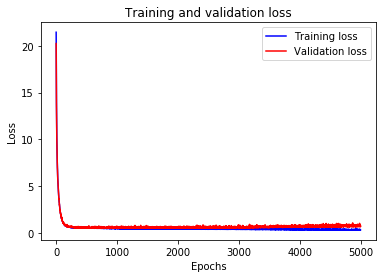

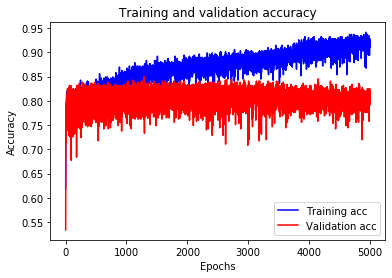

In [27]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, loss_values, 'b', label='Training loss') 
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_dict['accuracy'] 
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc') 
plt.plot(epochs, val_acc, 'r', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend()
plt.show()

# make class predictions with the model
#predictions = model.predict_classes(dev_X.T)
#for i in range(dev_X.shape[1]):
#    if predictions[i] != dev_Y.T[i]:
#        print('%s => %d (expected %d)' % (dev_X.T[i].tolist(), predictions[i], dev_Y.T[i]))

In [17]:
test_X= data_train_simple("test.csv", split = False)
predict = model.predict_classes(test_X.T)
predictions = predict.tolist()
test_data = pd.read_csv("test.csv")
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output['Survived'] = output['Survived'].str.get(0)
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [18]:
# load model
#model = load_model('model.h5')
# summarize model.
#model.summary()
model.save("model_titanic.h5")
print("Saved model to disk")

Saved model to disk
